In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from iflow.dataset import gen_cycle_dataset
from data.human_robot_interaction_data.read_hh_hr_data import read_data
from iflow.dataset.iros_dataset import IROS

import torch
import torch.optim as optim
from iflow.dataset import drums_dataset, gen_cycle_dataset, hr_cycle_dataset
from torch.utils.data import DataLoader
from iflow import model
from iflow.trainers import cycle_dynamics_train
from iflow.utils.generic import to_torch

import matplotlib.pyplot as plt
import numpy as np

from iflow.visualization import visualize_vector_field, visualize_trajectories
from iflow.test_measures.log_likelihood import cycle_log_likelihood

In [2]:

batch_size = 100
depth = 10
## optimization ##
lr = 0.001
weight_decay = 0.1
## training variables ##
nr_epochs = 1000

device = torch.device('cpu')


def main_layer(dim):
    return  model.ResNetCouplingLayer(dim)

def create_flow_seq(dim, depth):
    chain = []
    for i in range(depth):
        chain.append(main_layer(dim))
        chain.append(model.RandomPermutation(dim))
        chain.append(model.LULinear(dim))
    chain.append(main_layer(dim))
    return model.SequentialFlow(chain)

In [32]:
data_p, data_q, names, times = read_data('data/human_robot_interaction_data/hh/p1/hand_shake_s1_1.csv')
segments = np.load('data/human_robot_interaction_data/hh/segmentation/hand_shake_1.npy')
trajs_p = [data_p[s[0]:s[1], :, :] for s in segments]
trajs_q = [data_q[s[0]:s[1], :, :] for s in segments]

# downsample
stepsize = 1
cutoff = 400
offset_start = 130

trajs_p_downsampled = np.array([a[::stepsize,:,:][offset_start:cutoff] for a in trajs_p])
trajs_p_downsampled.shape
trajs_p = trajs_p_downsampled.reshape(19,cutoff-offset_start,26*3)[:,:,-2:]

trajs_q_downsampled = np.array([a[::stepsize,:,:][offset_start:cutoff] for a in trajs_q])
trajs_q_downsampled.shape
trajs_q = trajs_q_downsampled.reshape(19,cutoff-offset_start,26*4)[:,:,-8:-6]

In [33]:
dim_p = 2
dim_q = 2

In [34]:
trajs_p.shape, trajs_q.shape

((19, 270, 2), (19, 270, 2))

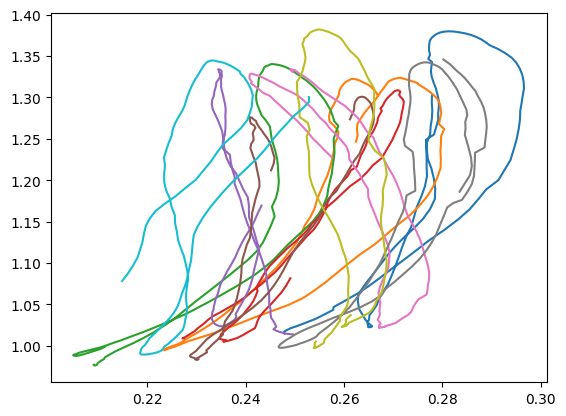

In [35]:
for i in range(0,10):
    plt.plot(trajs_p[i,offset_start:,1],trajs_p[i,offset_start:,0])

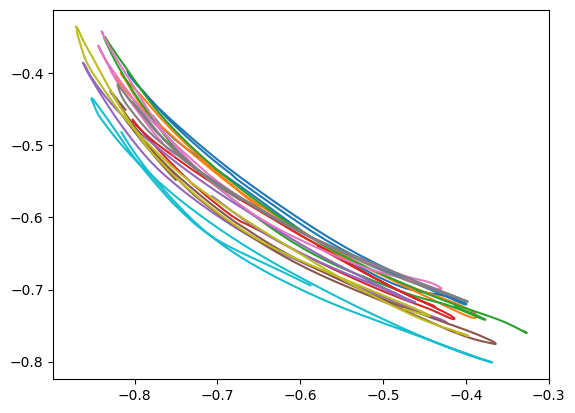

In [36]:
for i in range(0,10):
    plt.plot(trajs_q[i,offset_start:,0],trajs_q[i,offset_start:,1])

In [37]:
data = hr_cycle_dataset.HRCycleDataset(trajs_p, trajs_q, dim_p, dim_q)

In [38]:
T_period = (2*np.pi)/data.w
params = {'batch_size': batch_size, 'shuffle': True}
dataloader = DataLoader(data, **params)

In [39]:
lsd = model.LinearLimitCycle(dim_p + dim_q, device, dt=data.dt, T_period=T_period)
flow_human = create_flow_seq(dim_p, depth)
flow_robot = create_flow_seq(dim_q, depth)
iflow = model.HumanRobotFlow(dynamics=lsd, model_human=flow_human,
                             model_robot=flow_robot).to(device)

params = list(flow_human.parameters()) + list(flow_robot.parameters()) + list(lsd.parameters())
optimizer = optim.Adamax(params, lr = lr, weight_decay= weight_decay)

In [40]:
def hr_cycle_dynamics_train(iflow, x, y):
    ## Separate Data ##
    y0 = x
    y1 = y[0]
    step = y[1][0]
    phase = y[2]
    ## Evolve dynamics forward ##
    x0_h, x0_r, log_det_J_x0_h, log_det_J_x0_r = iflow(y0)
    x1_h, x1_r, log_det_J_x1_h, log_det_J_x1_r = iflow(y1)

    x0 = torch.cat([x0_h, x0_r], dim=1)
    x1 = torch.cat([x1_h, x1_r], dim=1)

    ### Forward Conditioning ###
    log_p_z1 = iflow.dynamics.cartesian_cond_log_prob(x0, x1, T=step)
    log_trj = log_p_z1 + log_det_J_x1_h.squeeze() + log_det_J_x1_r.squeeze()

    ### Stable Point ###
    log_p_z0 = iflow.dynamics.stable_log_prob(x0, ref_phase=phase)
    log_stable = log_p_z0 + log_det_J_x0_h.squeeze() + log_det_J_x0_r.squeeze()

    log_total = torch.mean(log_stable) + torch.mean(log_trj)
    return -log_total

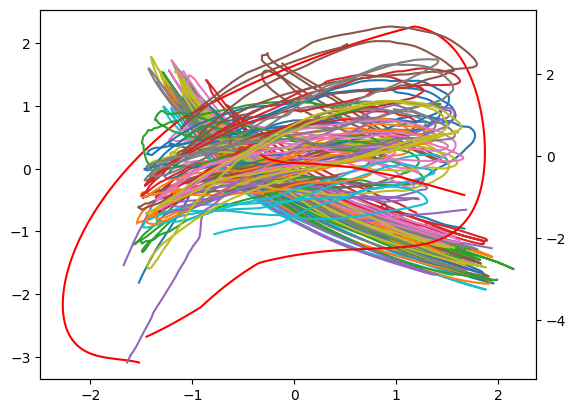

KeyboardInterrupt: 

In [55]:
for i in range(nr_epochs):
    # Training
    for local_x, local_y in dataloader:
        dataloader.dataset.set_step()
        optimizer.zero_grad()
        loss = hr_cycle_dynamics_train(iflow, local_x, local_y)
        loss.backward(retain_graph=True)
        optimizer.step()

    ## Validation ##
    if i%10 == 0:
        with torch.no_grad():
            iflow.eval()

            # plotting
            y0 = torch.from_numpy(data.train_data[0][0][None, :]).float().to(device)
            y0_h = y0[:, :2]
            y0_r = y0[:, 2:]

            trj_h, trj_r = iflow.generate_trj(y0_h, y0_r, T=data.train_data[0].shape[0])
            trj_h = trj_h.detach().cpu().numpy()
            trj_r = trj_r.detach().cpu().numpy()
            for t in data.train_data[:, :, data.dim_h:]:
                plt.plot(t[:,0], t[:,1])
            plt.plot(trj_h[:,0], trj_h[:,1], 'r')

            plt.twinx()
            for t in data.train_data[:, :, :data.dim_h]:
                plt.plot(t[:,0], t[:,1])

            plt.plot(trj_r[:,0], trj_r[:,1], 'r')

            plt.show()

            # likelihood
            # step = 20
            # trj = data.train_data[0]
            # trj_x0 = to_torch(trj[:-step,:], device)
            # trj_x1 = to_torch(trj[step:,:], device)
            # phase = to_torch(data.train_phase_data[0][:-step], device)
            # cycle_log_likelihood(trj_x0, trj_x1, phase, step, iflow, device)

In [50]:
dim_h = 2
dim_r = 2

In [51]:
y0 = torch.from_numpy(data.train_data[0][0][None, :]).float().to(device)
y0_h = y0[:, :dim_h]
y0_r = y0[:, dim_h:]

In [52]:
y = torch.from_numpy(data.train_data[0]).float().to(device)
y_h = y[:, :dim_h]
y_r = y[:, dim_h:]

In [53]:
out = iflow.generate_trj_hr(y0_h, y0_r, y_h)
out = out.detach().numpy()

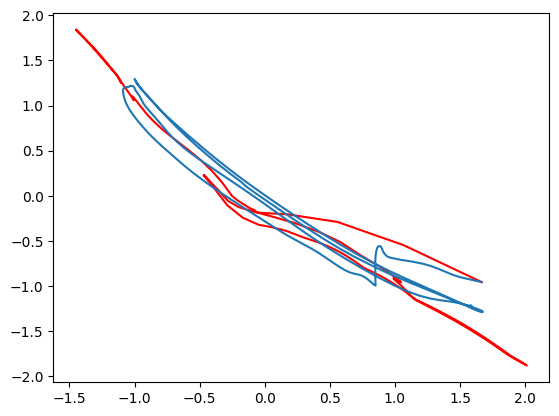

In [54]:
plt.plot(out[:, 0], out[:, 1], 'r')
plt.plot(data.train_data[0][:,2], data.train_data[0][:,3])